In [2]:
import os
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from palettable.colorbrewer.sequential import YlGn_8
from palettable.cartocolors.sequential import PurpOr_6
from palettable.cartocolors.diverging import Geyser_7
from palettable.colorbrewer.diverging import PuOr_7
from palettable.cartocolors.qualitative import Vivid_4
from palettable.cartocolors.qualitative import Pastel_4

from ideotype.data_process import read_data, agg_sims, fetch_sim_values, parse_mature
from ideotype.analysis import identify_top_phenos, rank_all_phenos, rank_top_phenos
from ideotype.figures import plot_sims_raw, plot_sims_phenostage
from ideotype.init_params import params_sample
from ideotype.utils import read_sim, fold
from ideotype import DATA_PATH
from ideotype.figures import plot_params_heatmap

In [3]:
run_name = 'present'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

# set site as int for dataframe emrging purposes
df_all.site = df_all.site.astype(int)
df_stuck.site = df_stuck.site.astype(int)
df_wea.site = df_wea.site.astype(int)

# Queried maizsim outputs
df_sims = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_yield.csv'))
df_phys = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_phys.csv'))
df_carbon = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_carbon.csv'))
df_mass = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_mass.csv'))
df_leaves = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_leaves.csv'))
df_waterdeficit = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_waterdeficit_sum = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit_sum.csv'))
df_waterpotential = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterpotential.csv'))
df_phenology = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_pheno.csv'))
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_gseason_climate = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))

Text(0, 0.5, 'grain-fill length')

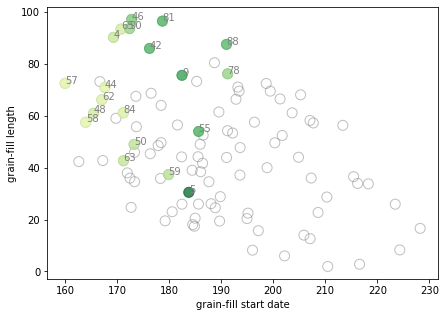

In [4]:
# fetch gf start dates & gf length
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']

# fetch top phenos
phenos = rank_top_phenos('present',20,1,1)[:20]

# visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

ax.scatter(gf_startdates, gf_lengths, alpha=0.5, s=100,
           facecolor='none', edgecolor='grey')

for pheno in phenos:
    ax.annotate(pheno, (gf_startdates[pheno], gf_lengths[pheno]), color='grey')

gfs = [gf_startdates[pheno] for pheno in phenos]
gfl = [gf_lengths[pheno] for pheno in phenos]

LAs = []
for pheno in phenos:
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)

ax.scatter(gfs, gfl, c=LAs, s=100, cmap=YlGn_8.mpl_colormap,
           vmin=500, vmax=8000, alpha=0.8)

ax.set_xlabel('grain-fill start date')
ax.set_ylabel('grain-fill length')

Text(0, 0.5, 'grain-fill length')

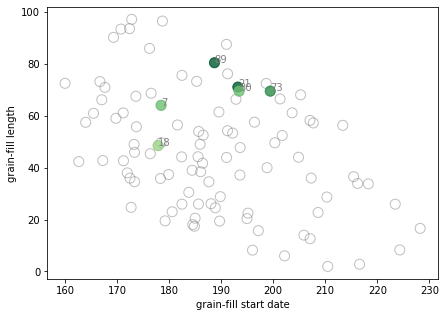

In [198]:
# fetch gf start dates & gf length
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']

# fetch top phenos
#phenos = rank_top_phenos('present',20,1,1)[:50]
#phenos = [73,25,21,30,89,12,54]
phenos = [18,21,73,30,89,7]

# visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

ax.scatter(gf_startdates, gf_lengths, alpha=0.5, s=100,
           facecolor='none', edgecolor='grey')

for pheno in phenos:
    ax.annotate(pheno, (gf_startdates[pheno], gf_lengths[pheno]), color='grey')

gfs = [gf_startdates[pheno] for pheno in phenos]
gfl = [gf_lengths[pheno] for pheno in phenos]

LAs = []
for pheno in phenos:
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)

ax.scatter(gfs, gfl, c=LAs, s=100, cmap=YlGn_8.mpl_colormap,
           vmin=500, vmax=8000, alpha=0.8)

ax.set_xlabel('grain-fill start date')
ax.set_ylabel('grain-fill length')

## Strategies

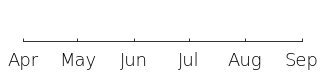

In [601]:
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(91,244)
ax.set_xticks([91, 121, 152, 182, 213, 244])
ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], 
                   fontweight='light', fontsize=18)
ax.tick_params(axis='x', direction='in', pad=10)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_visible(False)

fig.subplots_adjust(bottom=0.4)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/phenostage_timeline.png', format='png', dpi=800)

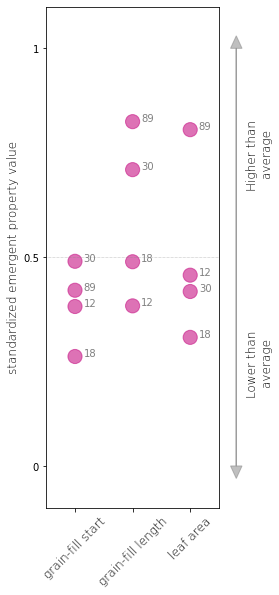

In [212]:
# phenos of interest
phenos = [18,30,89,12]  # high improvers that made it into top 20
#phenos = [21,25,73]  # greatest improvement

# fetch emergent properties
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']

LAs = []
for pheno in np.arange(100):
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)
    
# visualization
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1,1,1)

c5 = 'mediumvioletred'
c6 = 'pink'

colors = [c5,c5,c5,c5]
#colors= [c6,c6,c6]

alphas = [0.6,0.6,0.6,0.6]
#alphas = [0.8,0.8,0.8]

gf_start_std = [(gf_startdates[pheno]-min(gf_startdates))/(max(gf_startdates)-min(gf_startdates)) for pheno in phenos]
gf_len_std = [(gf_lengths[pheno]-min(gf_lengths))/(max(gf_lengths)-min(gf_lengths)) for pheno in phenos]
la_std = [(LAs[pheno]-min(LAs))/(max(LAs)-min(LAs)) for pheno in phenos]

ax.scatter([1]*len(phenos), gf_start_std, c=colors, s=200, alpha=alphas)
ax.scatter([2]*len(phenos), gf_len_std, c=colors, s=200, alpha=alphas)
ax.scatter([3]*len(phenos), la_std, c=colors, s=200, alpha=alphas)

for item, pheno in enumerate(phenos):
    ax.annotate(pheno, (1.15, gf_start_std[item]), color='grey')
for item, pheno in enumerate(phenos):
    ax.annotate(pheno, (2.15, gf_len_std[item]), color='grey')
for item, pheno in enumerate(phenos):
    ax.annotate(pheno, (3.15, la_std[item]), color='grey')

ax.set_xlim(0.5, 3.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['grain-fill start', 'grain-fill length', 'leaf area'], 
                   rotation=45, fontweight='light', fontsize=12)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_ylabel('standardized emergent property value', fontweight='light', fontsize=12)
ax.axhline(y=0.5, color='grey', linewidth=0.5, linestyle=':')


ax.arrow(3.8, 0, 0, 1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)
ax.arrow(3.8, 1, 0, -1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)

ax.annotate('Lower than \naverage', (4.2, 0.25), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('Higher than \naverage', (4.2, 0.75), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_strategies.png', format='png', dpi=800)

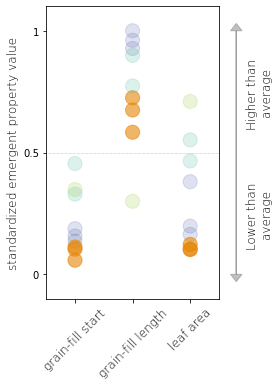

In [241]:
# phenos of interest
phenos = [4,65,46,  # slow aging
          44,58,62,  # stress averters
          88,9,  # high yielders
          5]  # compensator

# fig parameters
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
#c5 = 'mediumvioletred'

colors = [c1, c1, c1,
          c2, c2, c2,
          c3, c3, c4]
#          c5]

alphas=[0.6]*3

# fetch emergent properties & standardize
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']
LAs = []
for pheno in np.arange(100):
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)

gf_start_std = [(gf_startdates[pheno]-min(gf_startdates))/(max(gf_startdates)-min(gf_startdates)) for pheno in phenos]
gf_len_std = [(gf_lengths[pheno]-min(gf_lengths))/(max(gf_lengths)-min(gf_lengths)) for pheno in phenos]
la_std = [(LAs[pheno]-min(LAs))/(max(LAs)-min(LAs)) for pheno in phenos]

    
# visualization
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(1,1,1)

ax.scatter([1]*len(phenos), gf_start_std, c=colors, s=200, alpha=alphas)
ax.scatter([2]*len(phenos), gf_len_std, c=colors, s=200, alpha=alphas)
ax.scatter([3]*len(phenos), la_std, c=colors, s=200, alpha=alphas)

#for item, pheno in enumerate(phenos):
#    ax.annotate(pheno, (1.15, gf_start_std[item]), color='grey')
#for item, pheno in enumerate(phenos):
#    ax.annotate(pheno, (2.15, gf_len_std[item]), color='grey')
#for item, pheno in enumerate(phenos):
#    ax.annotate(pheno, (3.15, la_std[item]), color='grey')

ax.set_xlim(0.5, 3.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['grain-fill start', 'grain-fill length', 'leaf area'], 
                   rotation=45, fontweight='light', fontsize=12)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_ylabel('standardized emergent property value', fontweight='light', fontsize=12)
ax.axhline(y=0.5, color='grey', linewidth=0.5, linestyle=':')


ax.arrow(3.8, 0, 0, 1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)
ax.arrow(3.8, 1, 0, -1, color='grey', alpha=0.5,
         head_length=0.03, head_width=0.2, clip_on=False)

ax.annotate('Lower than \naverage', (4.2, 0.25), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)
ax.annotate('Higher than \naverage', (4.2, 0.75), 
            ha='center', va='center', fontweight='light', 
            fontsize=12, rotation=90,
            annotation_clip=False)

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_strategies.png', format='png', dpi=800)

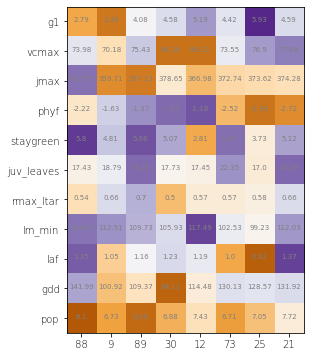

In [191]:
targeted_phenos = [88,9,89,30,12,73,25,21]
plot_params_heatmap(df_params, targeted_phenos)

## Mechanisms

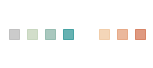

In [800]:
fig = plt.figure(figsize=(2.5,1))
ax = fig.add_subplot(1,1,1)

colors = ['darkgrey', 
          Geyser_7.mpl_colors[2],
          Geyser_7.mpl_colors[1],
          Geyser_7.mpl_colors[0],          
          Geyser_7.mpl_colors[-3],
          Geyser_7.mpl_colors[-2],
          Geyser_7.mpl_colors[-1]]

ax.scatter([1,2,3,4,6,7,8], [1,1,1,1,1,1,1],
            c=colors, marker='s', s=100, alpha=0.6)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/cpalette_phenostages.png', format='png', dpi=800)

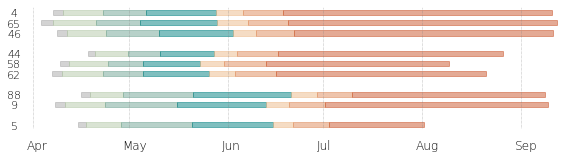

In [806]:
# identify targeted phenos
phenos = [4,65,46,44,58,62,88,9,5]
df_phenology_grouped = df_phenology.groupby(['cvar', 'pheno']).mean()
df_phenos = df_phenology_grouped.query(f'cvar in {phenos}')  

# set up phenostages
phenostages = [['"none"', '"Germinated"'],
               ['"Germinated"', '"Emerged"'],
               ['"Emerged"', '"Tasselinit"'],
               ['"Tasselinit"', '"Tasseled"'],
               ['"Tasseled"', '"Silked"'],
               ['"Silked"', '"grainFill"'],
               ['"grainFill"', '"Matured"']]
        
colors = ['darkgrey', 
          Geyser_7.mpl_colors[2],
          Geyser_7.mpl_colors[1],
          Geyser_7.mpl_colors[0],          
          Geyser_7.mpl_colors[-3],
          Geyser_7.mpl_colors[-2],
          Geyser_7.mpl_colors[-1]]

# visualization
fig = plt.figure(figsize=(10,2.5))

ax = fig.add_subplot(1,1,1)
ax.plot([85,270],[0,10], alpha=0)
ax.set_xlim(85,260)
ax.set_ylim(0.8,12.8)

jday_months = [91, 121, 152, 182, 213, 244, 274, 305, 335, 350]
for jday_month in jday_months:
    ax.axvline(x=jday_month, color='grey', linewidth=0.5, linestyle=':')

for phenostage, color in zip(phenostages, colors):
    df_phenostage1 = df_phenos[
        df_phenos.index.get_level_values('pheno') == f'{phenostage[0]}'].reset_index()
    df_phenostage1.index = df_phenostage1.cvar
    df_phenostage1 = df_phenostage1.reindex(phenos)

    df_phenostage2 = df_phenos[
        df_phenos.index.get_level_values('pheno') == f'{phenostage[1]}'].reset_index()
    df_phenostage2.index = df_phenostage2.cvar
    df_phenostage2 = df_phenostage2.reindex(phenos)

    cvars1 = np.arange(len(phenos))
    cvars2 = np.arange(len(phenos))

    jdays_start = np.empty(len(phenos))
    jdays_start[:] = np.nan
    jdays_start[cvars1] = list(df_phenostage1.jday.values)

    jdays_end = np.empty(len(phenos))
    jdays_end[:] = np.nan
    jdays_end[cvars2] = list(df_phenostage2.jday.values)

    jdays_len = [jend - jstart for jend, jstart in zip(jdays_end, jdays_start)]
    rankings = list(np.arange(len(phenos)))
    rankings.reverse()
    
    poss = [12,11,10,8,7,6,4,3,1]
    for item in np.arange(len(phenos)):
        rect = patches.Rectangle((jdays_start[item], poss[item]), 
                                 jdays_len[item], 0.5,
                                 color=color, alpha=0.5, clip_on=False)
        ax.add_patch(rect)

# invisible spines & axes
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='y', direction='in', pad=10)

# annotate x & y axis info
xs = [91, 121, 152, 182, 213, 244]
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
for item in np.arange(len(months)):
    ax.text(xs[item]-2, -1.2, months[item], 
            fontweight='light', fontsize=12, clip_on=False)

for pos, pheno in zip(poss, phenos):
    ax.text(85, pos-0.2, pheno, 
            fontweight='light', fontsize=11, clip_on=False, ha='center')

fig.subplots_adjust(bottom=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_phenostage_strategies.png', format='png', dpi=800)

### *** Try remaking these plots to show standardized values compared to all phenotypes and simplify y axis vvv

In [ ]:
df = df_phys
phenostage = '"Emerged"'
mechanism = 'An'
phenos_all = np.arange(100)
phenos = [4,65,46,44,58,62,88,9,5]
sims_all = fetch_sim_values(df, phenostage, mechanism, phenos_all)
sims = fetch_sim_values(df, phenostage, mechanism, phenos)
[(sim - min(sims_all))/max(sims_all) for sim in sims]

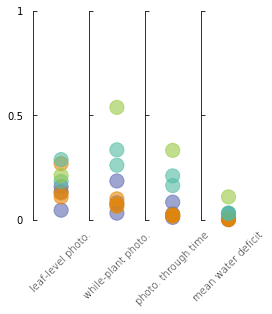

In [296]:
# identify phenos
phenos_all = np.arange(100)
phenos = [4,65,46,44,58,62,88,9,5]

# set up fig parameters
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1, c1, c1, c2, c2, c2, c3, c3, c4]
alphas=[0.6]*9

phenostage = '"Emerged"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
xlabels = ['leaf-level photo.', 'while-plant photo.', 'photo. through time', 'mean water deficit']

# visualization
fig = plt.figure(figsize=(4,5))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    sims_all = fetch_sim_values(df, phenostage, mechanism, phenos_all)
    sims = fetch_sim_values(df, phenostage, mechanism, phenos)
    sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    if count == 3:
        sims_all = [sim*-1 for sim in sims_all]
        sims = [sim*-1 for sim in sims]
        sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    ax.scatter([1]*len(phenos), sims_std,
               s=200, c=colors, alpha=alphas, clip_on=False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticks([0])
    ax.set_xticklabels([0])
    ax.set_xlabel(xlabels[count], rotation=45, labelpad=10,
                  fontsize=10, fontweight='light')
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.5,1])
    
    if count == 0:
        ax.set_yticklabels([0,0.5,1])
    else:
        ax.set_yticklabels(['','',''])
    ax.tick_params(axis='y', direction='in', pad=10)

fig.subplots_adjust(wspace=0, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_veg.png', format='png', dpi=800)

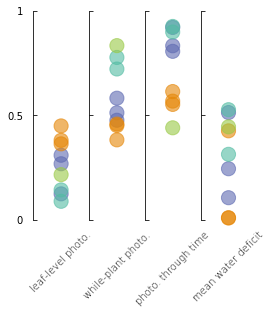

In [297]:
# identify phenos
phenos_all = np.arange(100)
phenos = [4,65,46,44,58,62,88,9,5]

# set up fig parameters
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1, c1, c1, c2, c2, c2, c3, c3, c4]
alphas=[0.6]*9

phenostage = '"grainFill"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
xlabels = ['leaf-level photo.', 'while-plant photo.', 'photo. through time', 'mean water deficit']

# visualization
fig = plt.figure(figsize=(4,5))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    sims_all = fetch_sim_values(df, phenostage, mechanism, phenos_all)
    sims = fetch_sim_values(df, phenostage, mechanism, phenos)
    sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    if count == 3:
        sims_all = [sim*-1 for sim in sims_all]
        sims = [sim*-1 for sim in sims]
        sims_std = [(sim - min(sims_all))/max(sims_all) for sim in sims]

    ax.scatter([1]*len(phenos), sims_std,
               s=200, c=colors, alpha=alphas, clip_on=False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticks([0])
    ax.set_xticklabels([0])
    ax.set_xlabel(xlabels[count], rotation=45, labelpad=10,
                  fontsize=10, fontweight='light')
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.5,1])
    if count == 0:
        ax.set_yticklabels([0,0.5,1])
    else:
        ax.set_yticklabels(['','',''])
    ax.tick_params(axis='y', direction='in', pad=10)

fig.subplots_adjust(wspace=0, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_rep.png', format='png', dpi=800)

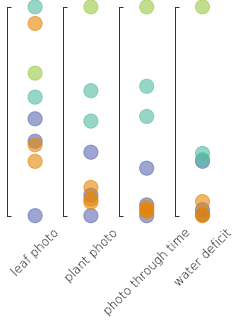

In [121]:
# set up plot parameters
phenostage = '"Emerged"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
ylims = [(15,22), (0, 0.06), (0,18), (-0.12, 0)]
xlabels = ['leaf photo', 'plant photo', 'photo through time', 'water deficit']
ylabels = ['leaf level photo.',  'whole plant level photo.', 
           'whole plant photo. through time', 'mean water deficit']
# visualization
fig = plt.figure(figsize=(4,5))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    sims = fetch_sim_values(df, phenostage, mechanism, phenos)
    
    if count == 3:
        sims = np.array(sims)*-1

    ax.scatter([1]*len(phenos), sims,
           s=200, c=colors, alpha=alphas, clip_on=False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    value_min = min(sims)
    value_max = max(sims)
    ax.set_xticks([0])
    ax.set_xticklabels([0])
    ax.set_xlabel(xlabels[count], rotation=45, labelpad=10,
                  fontsize=12, fontweight='light')
    ax.set_ylim([value_min, value_max])
    ax.set_yticks([value_min, value_max])
    ax.set_yticklabels(['',''])
    ax.tick_params(axis='y', direction='in', pad=10)

fig.subplots_adjust(wspace=0, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_veg.png', format='png', dpi=800)

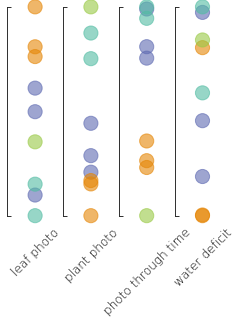

In [122]:
# set up plot parameters

phenostage = '"grainFill"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
ylims = [(15,22), (0, 0.06), (0,18), (-0.12, 0)]
xlabels = ['leaf photo', 'plant photo', 'photo through time', 'water deficit']
ylabels = ['leaf level photo.',  'whole plant level photo.', 
           'whole plant photo. through time', 'mean water deficit']
# visualization
fig = plt.figure(figsize=(4,5))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    sims = fetch_sim_values(df, phenostage, mechanism, phenos)
    
    if count == 3:
        sims = np.array(sims)*-1

    ax.scatter([1]*len(phenos), sims,
           s=200, c=colors, alpha=alphas, clip_on=False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    value_min = min(sims)
    value_max = max(sims)
    ax.set_xticks([0])
    ax.set_xticklabels([0])
    ax.set_xlabel(xlabels[count], rotation=45, labelpad=10,
                  fontsize=12, fontweight='light')
    ax.set_ylim([value_min, value_max])
    ax.set_yticks([value_min, value_max])
    ax.set_yticklabels(['',''])
    ax.tick_params(axis='y', direction='in', pad=10)

fig.subplots_adjust(wspace=0, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_rep.png', format='png', dpi=800)